In [31]:
import pandas as pd
import cv2
from darkflow.net.build import TFNet
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [32]:
# dataframes - test, train, valid 
test_path = 'test.csv'
train_path = 'train.csv'
valid_path = 'validate.csv'

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

In [33]:
test_df.sample(3)
# train_df.sample(3)
# valid_df.sample(3)

,Unnamed: 0,image_id,case_id,img_file,new_path,coords
113,539,556,446,/data/cimalab/thyroid/60_1.jpg,data/resized_imgs/img_691,"[array([136, 135, 42, 42], dtype=object), arra..."
76,355,370,295,/data/cimalab/thyroid/278_1.jpg,data/resized_imgs/img_491,"[array([102, 110, 94, 55], dtype=object), arra..."
48,215,222,167,/data/cimalab/thyroid/160_1.jpg,data/resized_imgs/img_267,"[array([188, 33, 218, 115], dtype=object)]"


In [34]:
options = {
    'model': 'cfg/tiny-yolo-voc-1c.cfg',
    'load': 2500,
    'threshold': 0.1,
    'labels': 'labels-1c.txt',
}



In [35]:
tfnet = TFNet(options)

Parsing cfg/tiny-yolo-voc-1c.cfg
Loading None ...
Finished in 0.00032806396484375s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 1

In [36]:
# for each result
def get_box(box_list, box_index):
    current = box_list[box_index]
    box = current['topleft']['x'], current['topleft']['y'], current['bottomright']['x'], current['bottomright']['y']
    return box

def get_true_box(df, img_id, box_index):
    row = df[df['image_id'] == img_id]
    coor_list = row['coords'].values
    box_info = coor_list[box_index]
    box = box_info[box_index][0], box_info[box_index][1], box_info[box_index][0]+box_info[0][2], box_info[box_index][1] + box_info[box_index][3]
    return box
    


In [37]:
# # iou calc, takes topleft, bottom right for each box

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and true_box
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [60]:
img_paths = test_df.new_path.values

img_paths = ['../' + path for path in img_paths]
img_ids = test_df.image_id.values

results = []
for item in img_paths:
    img = cv2.imread(item, cv2.IMREAD_COLOR)
    result = tfnet.return_predict(img)
    results.append(result)

In [81]:
results

all_boxes = []
for i in range(len(results)):
    num_boxes = len(results[i])
    boxes_by_img = []
    for j in range(num_boxes):
        box = get_box(results[i], j )
        boxes_by_img.append(box)
    all_boxes.append(boxes_by_img)
        
        
true

[[(333, 44, 401, 82), (354, 39, 445, 86)], [(243, 38, 319, 72), (193, 9, 363, 110)], [(228, 53, 328, 108)], [(172, 24, 308, 101)], [(189, 29, 283, 88)], [(134, 16, 352, 109)], [(209, 39, 284, 72), (243, 38, 326, 72)], [(213, 62, 273, 97), (227, 70, 323, 105), (211, 45, 348, 119)], [(144, 44, 346, 120)], [(187, 37, 364, 126)], [(153, 19, 388, 140)], [(203, 44, 348, 120)], [(199, 38, 348, 126)], [(177, 14, 363, 111)], [(148, 21, 398, 108)], [(118, 38, 195, 69), (88, 24, 219, 86), (293, 26, 445, 92), (318, 36, 413, 70)], [(233, 28, 321, 58)], [(174, 35, 379, 137)], [(247, 64, 312, 101), (221, 45, 338, 109)], [(109, 29, 381, 133)], [(240, 50, 325, 82), (263, 44, 369, 85)], [(206, 38, 348, 124)], [(205, 44, 347, 123), (237, 56, 313, 105)], [(228, 53, 328, 108)], [(196, 33, 349, 97)], [(172, 24, 308, 101)], [(209, 39, 284, 72), (243, 38, 326, 72)], [(199, 63, 281, 103), (208, 52, 342, 122)], [(196, 31, 363, 129)], [(232, 52, 318, 108)], [(247, 64, 312, 101), (221, 45, 338, 109)], [(193, 41, 

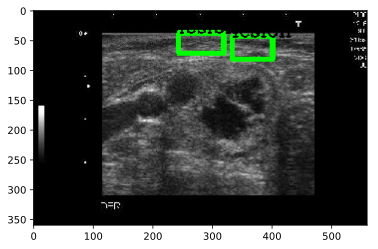

In [49]:
box_num = 0
t1 = (result[box_num]['topleft']['x'], result[box_num]['topleft']['y'])
br = (result[box_num]['bottomright']['x'], result[box_num]['bottomright']['y'])
label = result[box_num]['label']

img = cv2.rectangle(img, t1, br, (0,255,0), 8)
img = cv2.putText(img, label, t1, cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,0), 2)



plt.imshow(img)
plt.show()